#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Для начала проекта импортируем все необходимое

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit,  train_test_split, GridSearchCV 
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

Приступим к загрузке и рассмотрению данных.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]).resample('1H').sum()
data.index.is_monotonic

True

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [4]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Text(0.5, 1.0, 'Скользящее среднее за 24 часа')

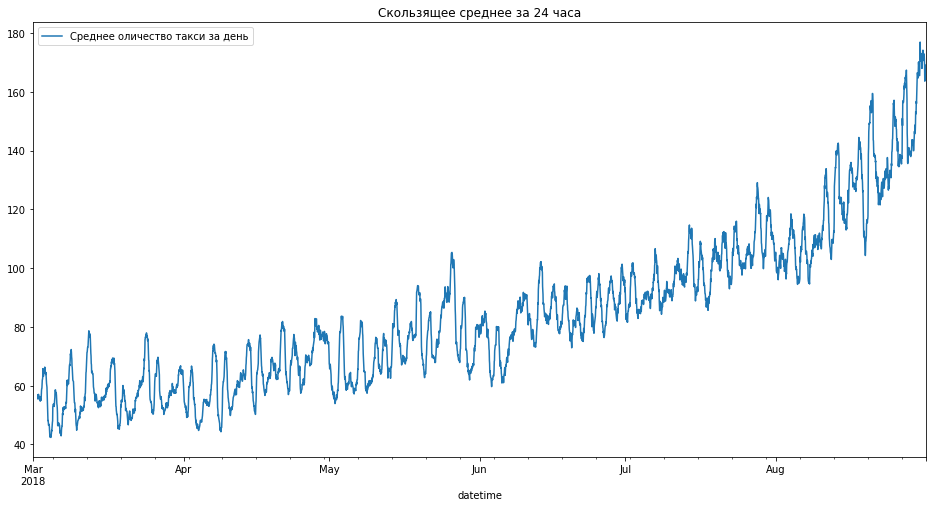

In [5]:
data['num_orders'].rolling(24).mean().plot(figsize=(16, 8))
plt.legend(['Среднее оличество такси за день'])
plt.title('Скользящее среднее за 24 часа')

* Данные чистые без пропусков
* Период март-август 2018 года
* Отсортированны
* Дела службы такси идут в гору

По таким данным просто составить предсказание в рамках следющего дня, с месяцами было бы сложнее.

## Анализ

Проведем более подробный анализ данных, рассмотрим тренды и сезонность. Сезонность рассматривать будем в рамках дня, недели и месяца.

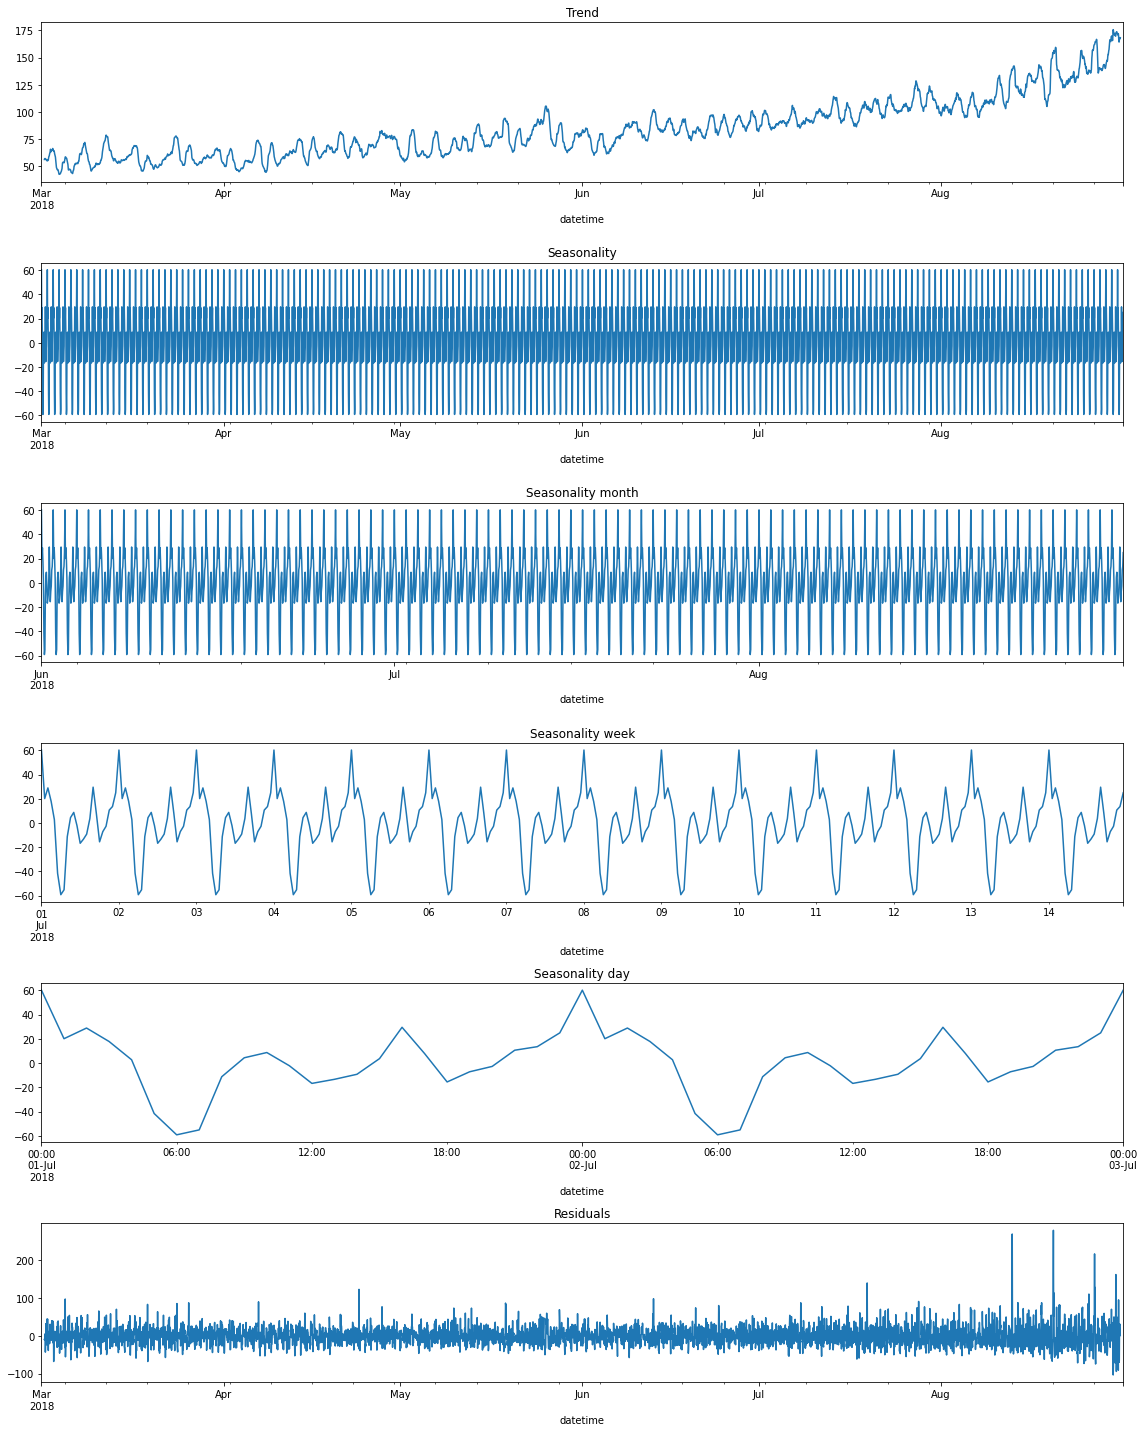

In [6]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(16, 20))
plt.subplot(611)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(612)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(613)
decomposed.seasonal['2018-06':'2018-08'].plot(ax=plt.gca())
plt.title('Seasonality month')
plt.subplot(614)
decomposed.seasonal['2018-07-01':'2018-07-14'].plot(ax=plt.gca())
plt.title('Seasonality week')
plt.subplot(615)
decomposed.seasonal['2018-07-01 00:00:00':'2018-07-3 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonality day')
plt.subplot(616)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

* Возрастающий тренд уже отмечался
* Общая, месячная и недельная сезонность ничего не дают
* А вот дневная говорит о максимальной просадке заказов к 6,00 и их пику в полуночи
* Судя по увелечению остаточков в конце графика, можно предположить что результат тестирования модели будет несколько хуже чем при обучении

## Обучение

Для обучения сгенерируем признаки 

* День недели
* Час

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hours'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:,0].shift(lag)

    data['rolling_mean'] = data.iloc[:,0].shift().rolling(rolling_mean_size).mean() 

In [8]:
make_features(data, 24, 12)
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   dayofweek     4392 non-null   int64  
 2   hours         4392 non-null   int64  
 3   lag_1         4392 non-null   float64
 4   lag_2         4392 non-null   float64
 5   lag_3         4392 non-null   float64
 6   lag_4         4392 non-null   float64
 7   lag_5         4392 non-null   float64
 8   lag_6         4392 non-null   float64
 9   lag_7         4392 non-null   float64
 10  lag_8         4392 non-null   float64
 11  lag_9         4392 non-null   float64
 12  lag_10        4392 non-null   float64
 13  lag_11        4392 non-null   float64
 14  lag_12        4392 non-null   float64
 15  lag_13        4392 non-null   float64
 16  lag_14        4392 non-null   float64
 17  lag_15        4392 non-null

Разделим выборку и подготовим данные.

In [9]:
def features_target_split(data,target):
    features = data.drop(target, axis=1)
    target = data[target]
    return features, target

In [10]:
train,test = train_test_split(data, test_size=0.1, shuffle=False)
features_test, target_test = features_target_split(test,'num_orders')
features_train, target_train = features_target_split(train,'num_orders')

In [11]:
scaler = StandardScaler()
scaler.fit(features_train.iloc[:, 2:])
features_train.iloc[:, 2:] = scaler.transform(features_train.iloc[:, 2:])
features_test.iloc[:, 2:] = scaler.transform(features_test.iloc[:, 2:])

In [12]:
results = pd.DataFrame(columns = ['model', 'rmse'])

In [13]:
cv = TimeSeriesSplit(n_splits=5).split(features_train)
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
score_lr = cross_val_score(lr_model, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)
results = results.append({'model' : 'LinearRegression',
                     'rmse' : round(np.mean(-score_lr)**0.5, 2)}, ignore_index=True)

Для более сложной модели воспользуемся GridSearchCV

In [14]:
cat_column = ['hours', 'dayofweek']

In [15]:
random_state = 12345
LGBMR_model = LGBMRegressor(random_state=random_state,loss_function='RMSE', cat_features=cat_column)

parameters = [{'max_depth': [5,10],
               'learning_rate': [0.07],
               'n_estimators': [190]}]

LGBMR_model_gscvts = GridSearchCV(LGBMR_model, param_grid=parameters, scoring='neg_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=5), verbose=True)
LGBMR_model_gscvts.fit(features_train, target_train)

results = results.append({'model' : 'LGBMRegressor',
                     'rmse' : abs(LGBMR_model_gscvts.best_score_) ** 0.5}, ignore_index=True)

LGBMR_model_gscvts.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown p

{'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 190}

In [16]:
CBR_model = CatBoostRegressor(random_state=random_state, silent=True, loss_function='RMSE', cat_features=cat_column)

parameters = [{'max_depth': [5,10],
               'learning_rate': [0.1],
               'n_estimators': [360]}]

CBR_model_gscvts = GridSearchCV(CBR_model, param_grid=parameters, scoring='neg_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=5), verbose=True, n_jobs=-1)
CBR_model_gscvts.fit(features_train, target_train)

results = results.append({'model' : 'CatBoostRegressor',
                     'rmse' : abs(CBR_model_gscvts.best_score_) ** 0.5}, ignore_index=True)

CBR_model_gscvts.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 360}

In [17]:
results

,model,rmse
0,LinearRegression,27.370000
1,LGBMRegressor,24.891486
2,CatBoostRegressor,24.518738


CatBoostRegressor и LGBMRegressor показали себя примерно одинакого, но CatBoostRegressor лучше, по этому протестируем его.

## Тестирование

In [19]:
predict_test = CBR_model_gscvts.best_estimator_.predict(features_test)
print('rmse : {}'.format(mean_squared_error(predict_test, target_test) ** 0.5))

rmse : 39.4683657898092


Модель соответствует требуемым параметрам.

**Вывод:**

Были получены хорошие данные за период в 5 месяцев, достаточные для прогнозирования кол-ва заказов на следющий день.
Для обучения моделей были добавлены соответствующие признаки, после подбора модели результат тестирования показал ее удовлетворительное качество работы.